# CUSP WASTE GRA
___
# 1 - Compute ACS at Tract Level

In [432]:
import sys
import os
import numpy as np
%pylab inline

# read in pandas and geopandas for data processing
import pandas as pd
import geopandas as geo

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


## A - Get block "shares" in Census Tract 

From the census, I have the population and the housing numbers at the block level. I compute for each block the share of the census tract population/units that it contains. This will enable me to disaggregate the ACS data which is at the census tract level.

In [433]:
census = geo.GeoDataFrame.from_file(os.getenv('WASTE')+'/Data/block_pop2010/tabblock2010_36_pophu_nyc.shp')

In [434]:
sum_tract = census.groupby([census.COUNTYFP10,census.TRACTCE10]).sum() #Get the total population by census tract
sum_tract.columns = ['housing_tract', 'pop_tract']
sum_tract.reset_index(inplace=True) #Put the census & county nb as columns & not indexes

In [435]:
census2 = census.merge(sum_tract, on=['COUNTYFP10', 'TRACTCE10'])

census2['POP_SHARE'] = census2.POP10/census2.pop_tract
census2['HOUS_SHARE'] = census2.HOUSING10/census2.housing_tract

# Housekeeping: block-level variables are in capital letters, tract-level are not
census2 = census2.rename(columns = {'TRACTCE10': 'tractce10', 'COUNTYFP10': 'countyfp10',
                                'STATEFP10': 'statefp10'})

In [436]:
census2['tract_id'] = census2.BLOCKID10.str[:11] # Extract Census id from Block id
cols = census2.columns.tolist()[-1:] + census2.columns.tolist()[:-1] # Rearrange columns to put tract id first
census2 = census2[cols]

## B - Merge with ACS CT-level

I "attach" to each block the statistics of its census tracts. And then multiply those stats by the share of the block in the census tract in terms of housing or population (depending on the variable).

In [437]:
acs = pd.read_csv(os.getenv('WASTE') + '/Data/acs_m.csv')

In [438]:
merged = census2.merge(acs, on='tract_id')
merged = merged.drop('Unnamed: 0', 1) # Drop acs index
#merged.info()

In [439]:
#In hous are the variable at the household level (multiplied after by the share of tract units in the block)
#In ind are the variables at the individual level
hous = [c for c in merged.columns[15:] if c in ('hh_wchild', 'hh_tot', 'family', 'single', 
                                           'roomies', 'rooms', 'units') or c[:3] == 'inc']
ind = [c for c in merged.columns[15:] if c not in hous]

for c in merged.columns[15:]:
    if c in hous:
        merged[c.upper()] = np.round(merged[c]*merged.HOUS_SHARE)
        merged = merged.drop(c,1)
    else:
        merged[c.upper()] = np.round(merged[c]*merged.POP_SHARE)
        merged = merged.drop(c,1)

# 2 - Join Census and DSNY
## A - Get ACS data at the DSNY Section level

I have disaggregated the ACS data at the block-level. So for each block I know a range of statistics and the DSNY section in which it is, through a spatial join.

In [440]:
# Read in DSNY
dsny = geo.GeoDataFrame.from_file(os.getenv('WASTE')+'/Data/DSNY_Sections/DSNY_sections.shp')
print dsny.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 232 entries, 0 to 231
Data columns (total 8 columns):
District      232 non-null object
OBJECTID      232 non-null int64
Section_      232 non-null object
Sections      232 non-null object
Shape_Area    232 non-null float64
Shape_Leng    232 non-null float64
Zone          232 non-null object
geometry      232 non-null object
dtypes: float64(2), int64(1), object(5)
memory usage: 16.3+ KB
None


In [441]:
# view sections
# dsny.plot()

In [442]:
sys.path.append(os.getenv('WASTE') + '/wlib/')
from geopandas.tools import sjoin
from spatial import spatial_join

In [455]:
df = spatial_join(merged,dsny)

Note: When I do the spatial join, 200 blocks with non-null population are not matched with any section. Their cumulated population is equal to ~32,000 persons. Those are blocks outside the spatial boundaries of DSNY Sections.

In [475]:
print "Population before join: {0:,}".format(merged.POP13.sum())
print "Population after join: {0:,} \n".format(df[df.Sections.isnull() == False].POP13.sum())

print "Repartition of missing block by county:" 
print df.countyfp10[(df.Sections.isnull() == True) & (df.POP13 != 0) & (df.POP13.isnull() == False)].value_counts()

print "\nRepartition of blocks by county, total:"
print df.countyfp10.value_counts()

Population before join: 8,268,563.0
Population after join: 8,236,420.0 

Repartition of missing block by county:
081    145
061     16
005     15
085     13
047     11
dtype: int64

Repartition of blocks by county, total:
081    14509
047     9753
005     5460
085     5077
061     3902
dtype: int64


In [445]:
#I generate a table with the statistics sum by DSNY section
acs_section = df.groupby(df.Sections).sum()
acs_section.reset_index(inplace=True) #Put the census & county nb as columns & not indexes
acs_section.columns

Index([     u'Sections',     u'HOUSING10',         u'POP10', u'housing_tract',
           u'pop_tract',     u'POP_SHARE',    u'HOUS_SHARE',     u'HH_WCHILD',
             u'COLLEGE',      u'NCOLLEGE',          u'EMPL',        u'UNEMPL',
                u'HELP',         u'NHELP',        u'HH_TOT',         u'INC10',
               u'INC15',         u'INC20',         u'INC25',         u'INC30',
               u'INC35',         u'INC40',         u'INC45',         u'INC50',
               u'INC60',         u'INC75',        u'INC100',        u'INC125',
              u'INC150',        u'INC200',       u'INC200+',        u'FAMILY',
              u'SINGLE',       u'ROOMIES',      u'AGGR_INC',       u'IND_TOT',
             u'IND_MGT',      u'IND_SERV',      u'IND_SALE',     u'IND_CONST',
           u'IND_TRANS',         u'ROOMS',         u'UNITS',         u'POP13',
               u'CHILD',         u'ADULT',           u'OLD',      u'OBJECTID',
          u'Shape_Area',    u'Shape_Leng'],
      dt

I have kept "raw" numbers until this step. But to input those statistics in the model, I need them to be expressed relatively. I thus compute ratios for most statistics, and keep only the ratios at the section level.

In [446]:
pd.options.mode.chained_assignment = None
acs_final = acs_section[['Sections', 'HH_TOT', 'POP13']]

acs_final['hh_wchild'] = acs_section['HH_WCHILD']/acs_section['HH_TOT']
acs_final['college'] = acs_section['COLLEGE']/(acs_section['NCOLLEGE'] + acs_section['COLLEGE'])
acs_final['unempl'] = acs_section['UNEMPL']/(acs_section['EMPL'] + acs_section['UNEMPL'])
acs_final['help'] = acs_section['HELP']/(acs_section['HELP'] + acs_section['NHELP'])

acs_final['family'] = acs_section['FAMILY']/(acs_section['FAMILY'] + acs_section['SINGLE'] + acs_section['ROOMIES'])
acs_final['avg_inc'] = acs_section['AGGR_INC']/acs_section['POP13']
acs_final['mgt'] = acs_section['IND_MGT']/acs_section['IND_TOT']
acs_final['rooms'] = acs_section['ROOMS']/acs_section['UNITS']
acs_final['density'] = acs_section['POP13']/acs_section['ROOMS']
acs_final['adult'] = acs_section['ADULT']/(acs_section['CHILD'] + acs_section['ADULT'] + acs_section['OLD'])

Computing the median income is a little bit trickier, as I only have counts of number of household in each income bracket. I could create a new dataset with a point for each household and its corresponding income bracket. But I thought it would be easier to proceed otherwise:
1. I compute the cumulated frequency table for income
2. I compute the rank of the median observation ($\frac{n+1}{2}$ if n is odd, $\frac{n}{2}$ if n the number of observations is even).
3. I go through the cumulated frequency table and keep the first bracket for which the cumulated count is higher than the rank of the median observation.

In [448]:
INC = ['INC10', 'INC15', 'INC20', 'INC25', 'INC30', 'INC35', 'INC40', 'INC45',
       'INC50', 'INC60', 'INC75', 'INC100', 'INC125', 'INC150', 'INC200', 'INC200+']

df = acs_section[INC].cumsum(axis=1)
df['Sections'] = acs_section.Sections
df['m_rank'] = np.ceil(df['INC200+']/2)
df['median'] = 'INC10'

for index, row in df.iterrows():
    for cat in INC:
        if (df[cat][index] > df['m_rank'][index]):
            df['median'][index] = cat
            break
        else:
            continue

I finally merge the computed median income and the other statistics at the DSNY section level. Five sections have a percentage of households with children higher than one. In all of them, the total number of households with children is higher than the number of units, which does not make sense. I thus discard the statistic household with children for those five sections, on the basis of misreported statistic.

In [449]:
acs_final = acs_final.merge(b[['Sections', 'median']], on='Sections')
acs_final['hh_wchild'][acs_final['hh_wchild'] > 1] = np.nan
acs_final.head(2)

,Sections,HH_TOT,POP13,hh_wchild,college,unempl,help,family,avg_inc,mgt,rooms,density,adult,median
0,BKN011,10120,20437,0.184585,0.682689,0.068702,0.074682,0.381037,40821.693546,0.547385,3.996565,0.450343,0.764141,INC75
1,BKN012,16383,38057,0.292010,0.619310,0.078839,0.246616,0.445143,35408.281578,0.521961,3.592039,0.599899,0.723852,INC60


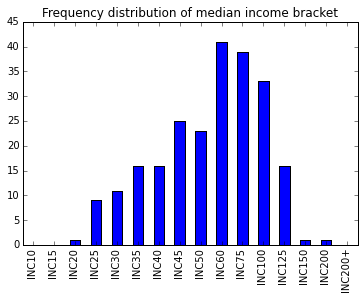

In [477]:
acs_final['median'].value_counts().reindex(INC).plot(kind='bar', title="Frequency distribution of median income bracket")

## B - Join ACS at the section level and DSNY waste data

In the end, I associate the waste data and the socio-demographic statistics in a complete table.

In [451]:
dsny_annual = pd.read_csv(os.getenv('WASTE')+'/Data/dsny_annual.csv')
dsny_annual = dsny_annual.rename(columns = {'Section_Code': 'Sections'})

In [478]:
acs_dsny = acs_final.merge(dsny_annual, on='Sections')
acs_dsny['year'] = complete.Dump_Time_Stamp.str[:4]
acs_dsny.head(2)

,Sections,HH_TOT,POP13,hh_wchild,college,unempl,help,family,avg_inc,mgt,rooms,density,adult,median,Material_Type_Code,Dump_Time_Stamp,Tons_Collected,year
0,BKN011,10120,20437,0.184585,0.682689,0.068702,0.074682,0.381037,40821.693546,0.547385,3.996565,0.450343,0.764141,INC75,1,2003-12-31 00:00:00,5292.83,2003
1,BKN011,10120,20437,0.184585,0.682689,0.068702,0.074682,0.381037,40821.693546,0.547385,3.996565,0.450343,0.764141,INC75,1,2004-12-31 00:00:00,9413.76,2004


In [480]:
acs_dsny.to_csv(os.getenv('WASTE') + '/Data/acs_dsny.csv')

In [479]:
import statsmodels.formula.api as smf
mod = smf.ols(formula='Tons_Collected ~ college + unempl + help + family + avg_inc + mgt + avg_inc + rooms',
              data = acs_dsny[(acs_dsny.year == '2013') & (acs_dsny.Material_Type_Code == 1)]).fit()

print(mod.summary())

                            OLS Regression Results                            
Dep. Variable:         Tons_Collected   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.302
Method:                 Least Squares   F-statistic:                     15.28
Date:                Sun, 25 Oct 2015   Prob (F-statistic):           2.68e-16
Time:                        15:38:20   Log-Likelihood:                -2173.5
No. Observations:                 232   AIC:                             4363.
Df Residuals:                     224   BIC:                             4391.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept   1.558e+04   3116.465      5.000      0.0

In [481]:
acs_dsny.columns

Index([          u'Sections',             u'HH_TOT',              u'POP13',
                u'hh_wchild',            u'college',             u'unempl',
                     u'help',             u'family',            u'avg_inc',
                      u'mgt',              u'rooms',            u'density',
                    u'adult',             u'median', u'Material_Type_Code',
          u'Dump_Time_Stamp',     u'Tons_Collected',               u'year'],
      dtype='object')

In [483]:
desc = ['DSNY Section id',
        'Total number of households',
        'Total population in 2013',
        'Percentage of households with children',
        'Percentage of persons with a college education',
        'Percentage of persons unemployed',
        'Percentage of persons receiving food stamps or cash from the government',
        'Percentage of family households',
        'Average household income',
        'Percentage of persons in a management position',
        'Average number of rooms by units',
        'Average number of individuals by room',
        'Percentage of persons aged 15-59',
        'Median income bracket',
        'Type of waste',
        'Time stamp',
        'Yearly collected tons',
        'Year']

metadata = dict()
for i,c in enumerate(acs_dsny.columns.tolist()):
    metadata[c] = desc[i]
pd.DataFrame.from_dict(metadata,orient='index').to_csv(os.getenv('WASTE') + '/Data/acs_dsny_metadata.csv')